# 1. Modelling Approach <a id='Introduction'></a>

<font color="red"><b>LONG RUNTIME WARNING - if you run this entire workbook from the start it will take around 3 hours. Tweak gridsearch param settings to cut down on runtime if testing code. </b></font>

<b> Selection of Models </b>

In this notebook we will be applying four different models to our dataset, namely:
<li> Naive Bayes (multinomial) approach - this will be our baseline model
<li> Logistic Regression approach
<li> Linear SVM approach </li>
<li> Decision Tree approach </li>

As explained in the problem statement, the reason for running multiple models is to evaluate differences in features selected and predictive power. Furthermore, this lends itself to a bagging ensemble approach should we choose to use the model for predictive purposes rather than inferential purposes in the future.

As for why these four models are chosen, all four support some form of feature importance method (either via .coefs_ or .get_feature_importances_), so we can evaluate the strength of features (words). Other classification models like KNearest Neighbors or Random Forests are not conducive to feature importance evaluations, and as such, will not be included in this project.

<br>
<br>
<b> Datasets </b>

Each model will be run on 4 different subsets of our master data:
<li> Title only
<li> Selftext only    
<li> Comments only
<li> Combined (Title + Selftext + Comments) </li>

The purpose of running multiple subsets is to investigate how much 'text' from the post is needed before the model can make a good prediction (accuracy > 80%). Can we make a good model using only the title text? How about only the self text? At what point does adding more content/text to the model have diminishing returns? Are there differences in the type of comments made in both subreddits?
<br>
<br>
<b> Interpreting text data </b>

Two vectorizers will also be tested: A count vectorizer vs a tfidf vectorizer.

CountVectorizer just counts the word frequencies, while the TFIDFVectorizer the value increases proportionally to count, but is offset by the frequency of the word in the corpus (the inverse document frequency). This helps to adjust for the fact that some words appear more frequently. The purpose of testing both is to see the effect on the top features selected - does the countvectorizer affect the top n predictive features?

<b> Metrics for Evaluating Model </b>

We will be using accuracy (correct predictions / total predictions) as the main metric for scoring our models, in combination with the AUC score (does the model do a good job of distinguishing the positive and the negative values?). The better the model is at making correct predictions (high accuracy), the better the selected features are at explaining the difference between the two.

# 2. Library Imports <a id='Imports'></a>

In [1]:
#General Imports
import pandas as pd
import numpy as np
import time
import random
import math, string
from collections import namedtuple, Counter
import scipy.stats as stats
from scipy.stats import norm
import datetime
import itertools
import requests
from bs4 import BeautifulSoup

#Plotting/Graphs
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline

#Modelling Imports
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words, text
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import tree

#Lets you view all columns in a dataframe when there are a LARGE number of columns
pd.set_option('display.max_columns', None)
#Fix for pandas truncating long strings (e.g. urls)
#If you don't run this, pandas will cut short your long urls and this breaks code that require urls
pd.set_option("display.max_colwidth", 10000)

C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# 3. Table of Contents <a id='Table of Contents'></a>

- <a href='#Introduction'>1. Modelling Approach</a>
- <a href='#Imports'>2. Library Imports</a>
- <a href='#Table of Contents'>3. Table of Contents</a>
- <a href='#Split'>4. Test Train Split</a>
    - <a href='#Function'>4.1 Modelling Function</a>
- <a href='#Baseline'>5. Baseline Model - Naive Bayes</a>
    - <a href='#NB Models'>5.1 Modelling Datasets</a>    
    - <a href='#NB Features'>5.2 Feature Analysis</a>
    - <a href='#NB Analysis'>5.3 Summary of Model</a>
- <a href='#Logreg'>6. Logistic Regression Model</a>
    - <a href='#Log Models'>6.1 Modelling Datasets</a>    
    - <a href='#Log Features'>6.2 Feature Analysis</a>
    - <a href='#Log Analysis'>6.3 Summary of Model</a>
- <a href='#SVM'>7.SVM Linear Model</a>
    - <a href='#SVM Models'>7.1 Modelling Datasets</a>    
    - <a href='#SVM Features'>7.2 Feature Analysis</a>
    - <a href='#SVM Analysis'>7.3 Summary of Model</a>
- <a href='#Decision'>8. Decision Tree Model</a>
    - <a href='#DT Models'>8.1 Modelling Datasets</a>    
    - <a href='#DT Features'>8.2 Feature Analysis</a>
    - <a href='#DT Analysis'>8.3 Summary of Model</a>
- <a href='#Conclusion'>9.Conclusion</a>

# 4. Test Train Split  <a id='Split'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

In [2]:
df_combined = pd.read_csv(r".\datasets\reddit_cleaned.csv")

In [3]:
#Kept NA in 'clean' export for evaluation purposes; there shouldn't be any NAs left but we will fill here just in case.
df_combined = df_combined.fillna('')

Below, we are creating a list of all EPL players to perform various lookups and analyses later on.

In [4]:
#Pull list of EPL players
res = requests.get('https://www.premierleague.com/news/1335777')
soup = BeautifulSoup(res.text, 'lxml')

#Extract player listings (those with more than 10 entries)
#Create a temp list to validate final output against if needed
temp_player_list = []
for n in soup.find_all("p"):
    if len(n)>10:
        temp_player_list += n

#Create final list of EPL players
#Lower case, split, and remove all punctuation
epl_players = []
for player in temp_player_list:
    epl_players += str(player).lower().replace('<br/>', '').replace('-', ' ').translate(str.maketrans('', '', string.punctuation)).split()

In [5]:
#Adding reddit titles to stop word list
#Review list - check if anything else is needed
text.ENGLISH_STOP_WORDS.union(['fpl', 'epl'])

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [6]:
X = df_combined[['title', 'selftext', 'comments', 'combined']]
y = df_combined['subreddit_name_prefixed']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=6)

In [8]:
#Check if shapes tally
print(X_train.shape, y_train.shape)

(1390, 4) (1390,)


### 4.1 Modelling Function  <a id='Function'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

In [9]:
#Finds true positive rate
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

<font color="red"><b>LONG RUNTIME WARNING - the code below takes 10-15 minutes to run depending on gridsearch settings!
Lower pipe param settings to reduce computation time if testing code. There are a total of 32 model variations being run, so... keep that in mind.</b></font>

In [10]:
#This monstrosity performs a grid search given a specified model and vectorizer, scores it on train/test sets,
#It then returns the test score (accuracy), AUC score, confusion matrix, the ROC/AUC curve, and a dataframe of features vs coefs
#IMPORTANT: what you call the model matters - use 'dt' for decision tree, 'svm' for SVM. 
#There's a better way to improve on this - maybe in the future.

def grid_fit(X, y, Xt, yt, model, vctrizer = 'cvec'):
    #Include 'fpl' and 'epl' as stop words
    vec_dict = {'cvec': CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(['fpl', 'epl'])),
                'tvec': TfidfVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(['fpl', 'epl']))}
    
    #Pipeline calls vectorizer, then calls classifier. No standardizing/scaling is needed as values are of the same scale.
    pipe = Pipeline([('vec', vec_dict[vctrizer]), model])

    pipe_params = {
    'vec__max_features': [1500, 2000, 2500, 3000, 3500, 4000],
    'vec__min_df': [1, 2, 3],
    'vec__max_df': [.9, .95],
    'vec__ngram_range': [(1,1), (1,2), (2,3)]}
    
    #Enable this if we want to manipulate params for decision tree, otherwise we let it use the default settings
    #Overfitting here is fine, since we are doing inference and not prediction
    #if model[0] == 'dt': #Adds more params for gridsearch if running a decision tree
            #pipe_params['dt__max_depth'] = [20, 30, 40, 50]
            #pipe_params['dt__min_samples_split'] = [10, 20, 30]    
            #pipe_params['dt__min_samples_leaf'] = [10, 20, 30]     


    #Fit gridsearch to train set   
    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
    gs.fit(X, y)
    
    #Score on test set and print both train/test scores
    test_score = gs.score(Xt, yt)
    print('Train Score: {}'.format(gs.best_score_))
    print('Test Score: {}'.format(test_score))
    
    #Generate Confusion Matrix
    predictions = gs.predict(Xt)
    tn, fp, fn, tp = confusion_matrix(yt, predictions).ravel()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print(gs.best_params_)
    
    #Generate feature list with strengths if the model supports this:   
    #For decision trees, we use feature_importances_, which captures gini impurity
    if model[0] == 'dt':
        feature_names = gs.best_estimator_.named_steps['vec'].get_feature_names()
        coefs_with_fns = sorted(zip(gs.best_estimator_.named_steps[model[0]].feature_importances_, feature_names))
        coefs_with_fns = pd.DataFrame(coefs_with_fns, columns = ['coef', 'feature'])
    
    #For linear svm models, coef_ returns a sparse matrix, which we need to unravel
    elif model[0] == 'svm':
        feature_names = gs.best_estimator_.named_steps['vec'].get_feature_names()
        coefs_with_fns = pd.DataFrame(gs.best_estimator_.named_steps[model[0]].coef_.A.transpose(), feature_names)
    
    #Return positive and negative features for naive bayes model
    elif model[0] == 'nb':
        feature_names = gs.best_estimator_.named_steps['vec'].get_feature_names()
        coefs_with_fns = pd.DataFrame([feature_names, 
                                      gs.best_estimator_.named_steps[model[0]].feature_log_prob_[0, :],
                                      gs.best_estimator_.named_steps[model[0]].feature_log_prob_[1, :]],
                                      index = ['feat', 'pos class', 'neg class']
                                     ).transpose()
        
    #Tries a coef_ method - if the model doesn't support a coef_ method, return 'no features'
    else:
        try:
            feature_names = gs.best_estimator_.named_steps['vec'].get_feature_names()
            coefs_with_fns = sorted(zip(gs.best_estimator_.named_steps[model[0]].coef_[0], feature_names))
            coefs_with_fns = pd.DataFrame(coefs_with_fns, columns = ['coef', 'feature'])
            
        except:
            #Throw an error if some random model unsupported method like knn is selected
            #KNN, RandomForests etc will still run, but it won't return a feature list
            coefs_with_fns = 'No features for selected model'

        
    
    #Generate AUC ROC curve
    #Generate dataframe mapping true values to pred probs
    pred_proba = [i[1] for i in gs.predict_proba(Xt)]

    pred_df = pd.DataFrame({'true_values': yt,
                        'pred_probs':pred_proba})
    
    # Create figure.
    plt.figure(figsize = (10,7))

    # Create threshold values.
    thresholds = np.linspace(0, 1, 200)

    tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    
    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve', color = 'g')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')
    
    #plots lines to connect graph to origin and 1,1 - the graph appears awkward otherwise.
    if model[0] == 'dt':
        plt.plot((0, 0), (0, tpr_values[len(tpr_values)-1]), color = 'g')
        plt.plot((fpr_values[0], 1), (1 , 1), color = 'g')
    
    #Calculate AUC score to output in 'return' tuple and print on graph
    auc_score = round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)
    
    # Label axes.
    plt.title(f'ROC Curve with AUC = {auc_score}', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);
    return (gs.best_params_ , test_score, auc_score, coefs_with_fns)

# 5. Baseline Model - Naive Bayes <a id='Baseline'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

For our baseline model, we will use Naive Bayes as a 'quick and dirty' means of classification. The multinomial variant of NB is selected here because it is suited to discrete data that have frequencies and counts.

However, because Naive Bayesian classifiers make stringent assumptions about data (i.e. independence among features), this model should generally not perform as well as a more complicated model.

That being said, the NB model is a good fit for NLP and text processing here due to the sheer number of features.
From the Python Datascience Handbook:
>As the dimension of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in every single dimension to be close overall). This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information. For this reason, simplistic classifiers like naive Bayes tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.

### 5.1 Modelling each Dataset <a id='NB Models'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

Here, we will run a multinomial Naive Bayes model on our 4 datasets, using 2 vectorizers, for a total of 8 data sets.
There are two goals here:
<li> Find out how each data set performs (i.e. is the title enough? Does having more words to work with make the model stronger?)
<li> Which vectorizer performs better? Does inter document frequency improve or worsen our results?

Train Score: 0.8611510791366906
Test Score: 0.8341708542713567
True Negatives: 232
False Positives: 65
False Negatives: 34
True Positives: 266
{'vec__max_df': 0.9, 'vec__max_features': 2000, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}


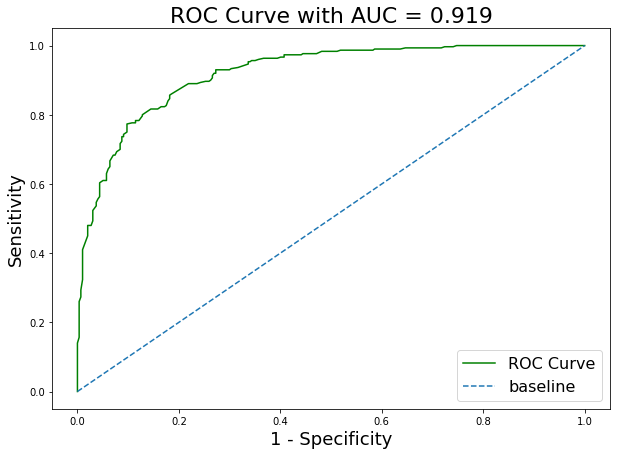

In [11]:
tvec_nb_title = grid_fit(X_train['title'], y_train, X_test['title'], y_test, model = ('nb', MultinomialNB()), vctrizer = 'tvec')

Train Score: 0.860431654676259
Test Score: 0.8358458961474037
True Negatives: 235
False Positives: 62
False Negatives: 36
True Positives: 264
{'vec__max_df': 0.9, 'vec__max_features': 1500, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}


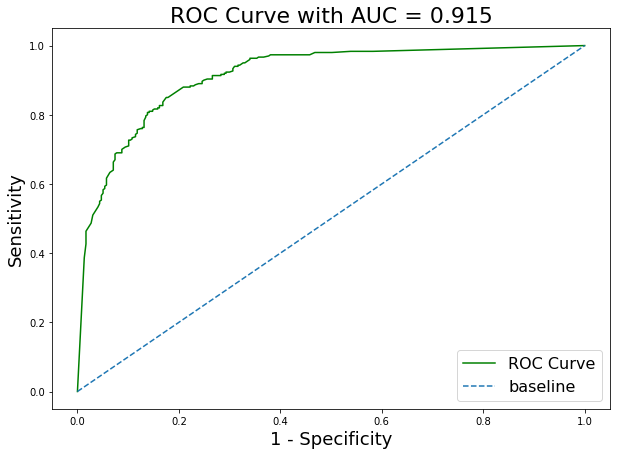

In [12]:
cvec_nb_title = grid_fit(X_train['title'], y_train, X_test['title'], y_test, model = ('nb', MultinomialNB()), vctrizer = 'cvec')

Train Score: 0.8028776978417266
Test Score: 0.7822445561139029
True Negatives: 192
False Positives: 105
False Negatives: 25
True Positives: 275
{'vec__max_df': 0.9, 'vec__max_features': 3500, 'vec__min_df': 2, 'vec__ngram_range': (1, 1)}


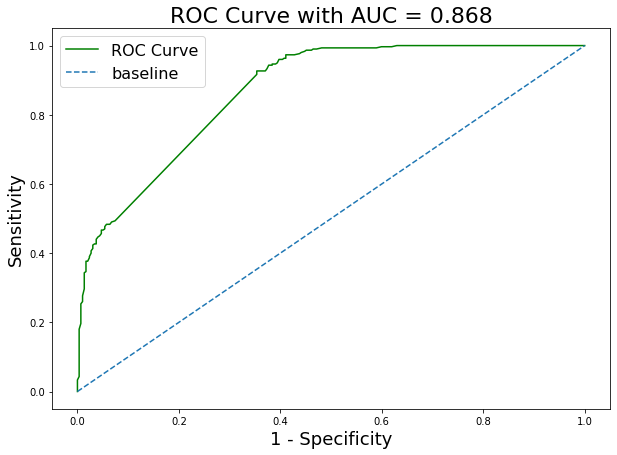

In [13]:
tvec_nb_selftext = grid_fit(X_train['selftext'], y_train, X_test['selftext'], y_test, model = ('nb', MultinomialNB()), vctrizer = 'tvec')

Train Score: 0.7589928057553957
Test Score: 0.7587939698492462
True Negatives: 164
False Positives: 133
False Negatives: 11
True Positives: 289
{'vec__max_df': 0.9, 'vec__max_features': 4000, 'vec__min_df': 1, 'vec__ngram_range': (1, 1)}


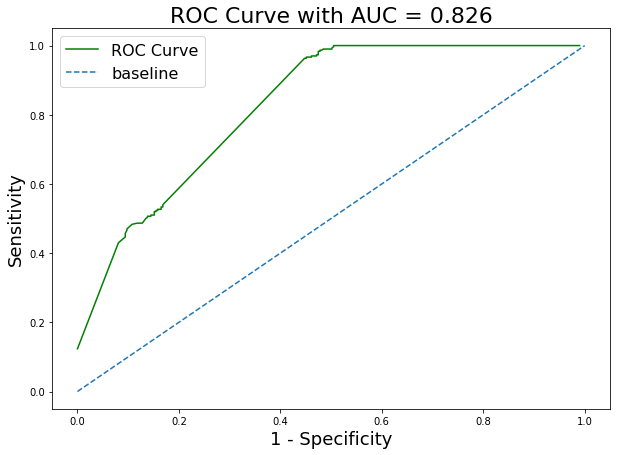

In [14]:
cvec_nb_selftext = grid_fit(X_train['selftext'], y_train, X_test['selftext'], y_test, model = ('nb', MultinomialNB()), vctrizer = 'cvec')

Train Score: 0.8848920863309353
Test Score: 0.8693467336683417
True Negatives: 246
False Positives: 51
False Negatives: 27
True Positives: 273
{'vec__max_df': 0.9, 'vec__max_features': 3000, 'vec__min_df': 2, 'vec__ngram_range': (1, 2)}


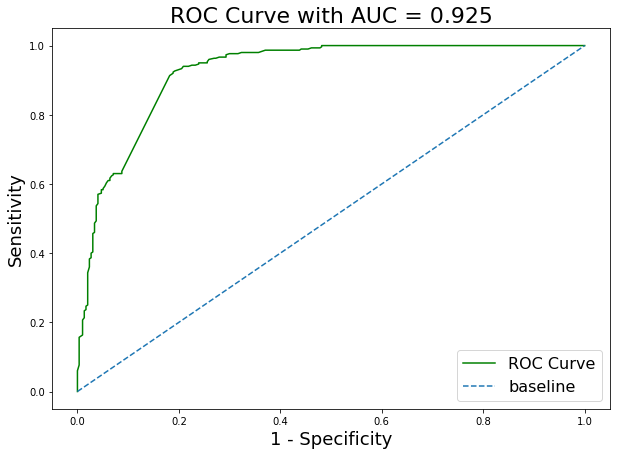

In [15]:
tvec_nb_comments = grid_fit(X_train['comments'], y_train, X_test['comments'], y_test, model = ('nb', MultinomialNB()), vctrizer = 'tvec')

Train Score: 0.8884892086330936
Test Score: 0.8743718592964824
True Negatives: 244
False Positives: 53
False Negatives: 22
True Positives: 278
{'vec__max_df': 0.9, 'vec__max_features': 4000, 'vec__min_df': 2, 'vec__ngram_range': (1, 2)}


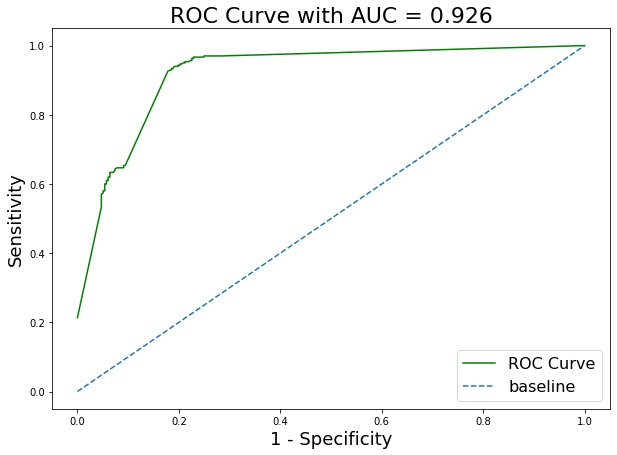

In [16]:
cvec_nb_comments  = grid_fit(X_train['comments'], y_train, X_test['comments'], y_test, model = ('nb', MultinomialNB()), vctrizer = 'cvec')

Train Score: 0.9294964028776979
Test Score: 0.9179229480737019
True Negatives: 271
False Positives: 26
False Negatives: 23
True Positives: 277
{'vec__max_df': 0.9, 'vec__max_features': 4000, 'vec__min_df': 3, 'vec__ngram_range': (1, 2)}


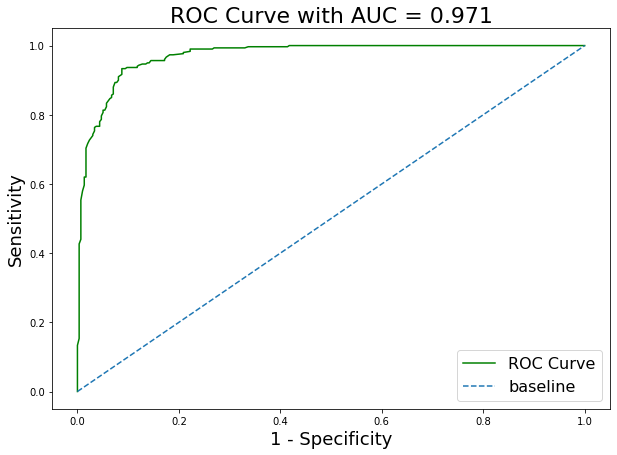

In [17]:
tvec_nb_combined = grid_fit(X_train['combined'], y_train, X_test['combined'], y_test, model = ('nb', MultinomialNB()), vctrizer = 'tvec')

Train Score: 0.9129496402877698
Test Score: 0.9078726968174204
True Negatives: 260
False Positives: 37
False Negatives: 18
True Positives: 282
{'vec__max_df': 0.9, 'vec__max_features': 3500, 'vec__min_df': 3, 'vec__ngram_range': (1, 1)}


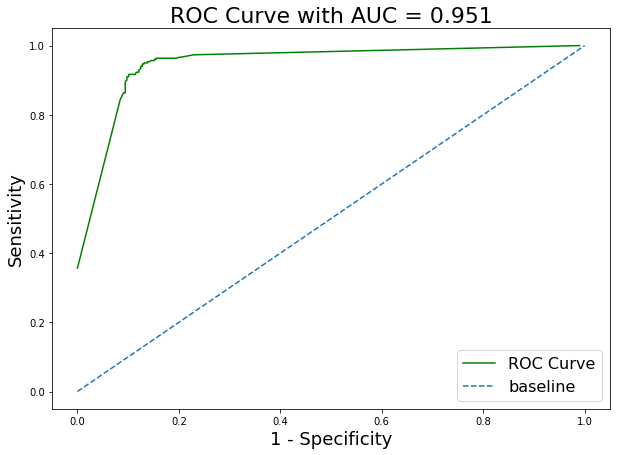

In [18]:
cvec_nb_combined = grid_fit(X_train['combined'], y_train, X_test['combined'], y_test, model = ('nb', MultinomialNB()), vctrizer = 'cvec')

### 5.2 Feature Analysis <a id='NB Features'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

###  Most important features 

The values below are the top 25 features for each reddit. Coefficients can be shown by calling, for example, tvec_nb_title[3], but we will only be examining the features after sorting for easy comparison. The values have been sorted by their empirical log probability of features given a class, P(x_i|y).

### Top 25 Features for r/FPL

In [31]:
pd.DataFrame([tvec_nb_title[3].sort_values(by = 'neg class', ascending = True)['feat'].head(25).values, 
              tvec_nb_selftext[3].sort_values(by = 'neg class', ascending = True)['feat'].head(25), 
              tvec_nb_comments[3].sort_values(by = 'neg class', ascending = True)['feat'].head(25), 
              tvec_nb_combined[3].sort_values(by = 'neg class', ascending = True)['feat'].head(25),
              cvec_nb_title[3].sort_values(by = 'neg class', ascending = True)['feat'].head(25),
              cvec_nb_selftext[3].sort_values(by = 'neg class', ascending = True)['feat'].head(25),
              cvec_nb_comments[3].sort_values(by = 'neg class', ascending = True)['feat'].head(25),
              cvec_nb_combined[3].sort_values(by = 'neg class', ascending = True)['feat'].head(25)], 
             index = ['tvec title', 'tvec selftext', 'tvec comments', 'tvec combined', 
                     'cvec title', 'cvec selftext', 'cvec comments', 'cvec combined']).transpose()

,tvec title,tvec selftext,tvec comments,tvec combined,cvec title,cvec selftext,cvec comments,cvec combined
0,ranked,laca,lundstram soyuncu,octoberwe reputation,implied odds,madison,pope button,zwaig
1,united wildcard,hesitant,mark sutherns,rico cantwell,scout,lufc,make week,killed
2,footballer tit,heraty,chat,rico dendoncker,mane,lu,mane auba,kneejerk
3,mohamed salah,hendrick,chasing,topical meme,gab,ltfpl,salah sterling,kneejerker
4,forget,helpful,masuaku,cleansheet,fyi gameweek,lt,salah son,borges
5,mohamed,hef,mcgovern,topical,fyi,loser,salah pukki,kouwenberg
6,minus podcast,heck,mci,high scoring,fun,lock,city player,kun
7,minus,heavily,change team,rico kelly,scoring odds,livmid,salah mount,landon
8,ming start,hga,change prediction,rico lundstram,friend gw,liv,city wolf,bonfield
9,ming,hay,change make,tomori wc,friday,lionel,salah kdb,lately


### Top 25 Features for r/EPL

In [32]:
pd.DataFrame([tvec_nb_title[3].sort_values(by = 'pos class', ascending = True)['feat'].head(25).values, 
              tvec_nb_selftext[3].sort_values(by = 'pos class', ascending = True)['feat'].head(25), 
              tvec_nb_comments[3].sort_values(by = 'pos class', ascending = True)['feat'].head(25), 
              tvec_nb_combined[3].sort_values(by = 'pos class', ascending = True)['feat'].head(25),
              cvec_nb_title[3].sort_values(by = 'pos class', ascending = True)['feat'].head(25),
              cvec_nb_selftext[3].sort_values(by = 'pos class', ascending = True)['feat'].head(25),
              cvec_nb_comments[3].sort_values(by = 'pos class', ascending = True)['feat'].head(25),
              cvec_nb_combined[3].sort_values(by = 'pos class', ascending = True)['feat'].head(25)], 
             index = ['tvec title', 'tvec selftext', 'tvec comments', 'tvec combined', 
                     'cvec title', 'cvec selftext', 'cvec comments', 'cvec combined']).transpose()

,tvec title,tvec selftext,tvec comments,tvec combined,cvec title,cvec selftext,cvec comments,cvec combined
0,nightmare,organised,banter era,domestic,maguire,chemistry,spur arsenal,kit
1,klopp win,kompany,salary,celtic,ha joined,rafael,gt gt,brentford
2,km,dazn,implementation,tifo,ha agreed,jose,optimistic,brugge
3,koscielny,known,baseball,anwar,praise,nahyan,competitive,martyn
4,team eye,knocked,informative,anwar el,pre season,tanguy,league world,stubhub
5,kyle,supporting,competitive,incident,prepared,namethatsong,season arsenal,strengthen
6,kyle walker,supposed,bbc,note big,gunner,nate,membership,matchthread
7,target,kit,inter,notsoofficial,gunnar solskjaer,nathaniel,viera,steven
8,tanguy ndombele,kinda,rivalry,notsoofficial reddit,gunnar,nbc,completion,mateo
9,laurent,surpass,inverting,card bad,gueye,sydney,premiership,cantona


From the above table, it is interesting to note that FPL players discuss A LOT about playersm whereas EPL redditors discuss teams more. The top features of the FPL reddit also contain a lot of FPL jargon.

The heavy use of jargon is a consideration to make when building a marketing campaign - is the FPL game easy for new players to get into? How will we facilitate new players getting into the game?

### What teams do r/EPL and r/FPL discuss?

The table below doesn't necessarily capture the most popular teams on each reddit. Rather, it captures the teams that differentiate the two - i.e. Watford is discussed a lot in r/FPL, but not a lot in r/EPL. This represents potential gaps in the market that we can target with a campaign.


In [21]:
team_list = ['manchester', 'city', 'united', 'pool', 'leicester', 'chelsea', 'arsenal',
             'tottenham', 'spurs', 'watford', 'norwich', 'bournemouth', 'villa', 'brighton',
            'burnley', 'crystal', 'everton', 'newcastle', 'southampton', 'saints', 'wolves', 'westham',
            'sheffield']

EPL redditors often discuss the following teams:

In [22]:
#We will look at our best performing model's features selected to look at what teams are differentiating FPL from EPL
tvec_nb_combined[3][tvec_nb_combined[3]['feat'].isin(team_list)].sort_values(by = 'pos class', ascending = True)

,feat,pos class,neg class
2679,pool,-8.21331,-8.83367
3607,tottenham,-8.02418,-6.47364
781,crystal,-7.72516,-7.00725
2081,manchester,-7.6843,-6.39963
451,burnley,-7.61128,-7.52467
395,bournemouth,-7.57096,-7.36896
3274,southampton,-7.56712,-7.51226
3187,sheffield,-7.52964,-6.75089
2326,newcastle,-7.52257,-6.54089
415,brighton,-7.4581,-7.07664


FPL redditors often discuss the following teams:

In [33]:
tvec_nb_combined[3][tvec_nb_combined[3]['feat'].isin(team_list)].sort_values(by = 'neg class', ascending = True)

,feat,pos class,neg class
2679,pool,-8.21331,-8.83367
3841,watford,-7.16504,-7.57606
451,burnley,-7.61128,-7.52467
3274,southampton,-7.56712,-7.51226
395,bournemouth,-7.57096,-7.36896
2380,norwich,-7.35389,-7.16179
415,brighton,-7.4581,-7.07664
781,crystal,-7.72516,-7.00725
1892,leicester,-7.00988,-6.92461
3187,sheffield,-7.52964,-6.75089


The coefficients here represent what differentiates the FPL reddit from the EPL reddit (i.e. what teams r/FPL are interested in, but r/EPL aren't interested in. Watford, Burnley, Southampton are not very popular teams, and aren't popular on r/EPL, but they are popular on r/FPL because their players are 'cheap' (you have a fixed budged in the FPL game to buy players) while giving good returns.

Both seem to really like Liverpool though..

### What players do r/EPL and r/FPL discuss

EPL redditors like discussing the following players...

In [34]:
tvec_nb_combined[3][tvec_nb_combined[3]['feat'].isin(epl_players)].sort_values(by = 'pos class', ascending = True).head(25)

,feat,pos class,neg class
3083,saliba,-9.10541,-7.98064
1345,gerrard,-9.10541,-8.23536
3116,scott,-9.10541,-8.69647
1650,ilkay,-9.10541,-8.69469
3459,tanguy,-9.10541,-8.12163
141,anwar,-9.10541,-8.76867
1751,jose,-9.10541,-8.17919
3786,virgil,-9.0936,-8.39842
2506,owen,-9.08127,-8.39932
3290,spencer,-9.08037,-8.95499


FPL redditors like discussing the following players...

In [25]:
tvec_nb_combined[3][tvec_nb_combined[3]['feat'].isin(epl_players)].sort_values(by = 'neg class', ascending = True).head(25)

,feat,pos class,neg class
407,brandon,-8.57626,-8.95891
3972,yarmolenko,-7.76684,-8.95891
2377,norris,-9.03084,-8.95891
774,cresswell,-7.99031,-8.95891
3335,stekelenburg,-8.88576,-8.95891
2139,mcgovern,-7.84171,-8.95891
1727,jeffrey,-8.43294,-8.95891
1352,gibson,-8.96044,-8.95524
3899,williams,-8.82842,-8.95524
3090,sarr,-8.4804,-8.95499


These are the top 25 players that differentiate FPL reddit from EPL reddit. These are niche players, from less popular teams. However, these players are very popular on r/FPL, because they yield good returns for their price.

EPL, on the other hand, likes discussing popular and even retired players/managers, like Henry, Ferguson, and Hazard (who left for Real Madrid last season).

### 5.3 Summary of NB Models and Analysis <a id='NB Analysis'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

The table below summarizes the accuracy scores from the 8 models.

In [35]:
nb_df = pd.DataFrame([[tvec_nb_title[1], tvec_nb_selftext[1],  tvec_nb_comments[1],  tvec_nb_combined[1]],
                     [cvec_nb_title[1],  cvec_nb_selftext[1], cvec_nb_comments[1], cvec_nb_combined[1]]],
                    index = ['tvec', 'cvec'], columns = ['title', 'selftext', 'comments', 'combined'])
nb_df

,title,selftext,comments,combined
tvec,0.834171,0.782245,0.869347,0.917923
cvec,0.835846,0.758794,0.874372,0.907873


The table below summarizes the AUC scores from the 8 models.

In [89]:
nb_df_AUC = pd.DataFrame([[tvec_nb_title[2], tvec_nb_selftext[2],  tvec_nb_comments[2],  tvec_nb_combined[2]],
                     [cvec_nb_title[2],  cvec_nb_selftext[2], cvec_nb_comments[2], cvec_nb_combined[2]]],
                    index = ['tvec', 'cvec'], columns = ['title', 'selftext', 'comments', 'combined'])
nb_df_AUC

,title,selftext,comments,combined
tvec,0.919,0.868,0.925,0.971
cvec,0.915,0.826,0.926,0.951


### Analysis of Naive Bayes Model

<b>Count Vectorizer vs Tfidf Vectorizer</b>

The tvec model generally outperforms the cvec model, with an interesting difference being on comments. With only comments, the cvec model performed slightly better.

The tvec model is also less computationally intensive, as it uses fewer features in its computation (max features param in the grid search).
    
<b> Datasets </b>

The model performs surprisingly well with just the title, considering the title on average contains just 10 words. However, as more features are added, the accuracy and AUC scores go up. One interesting thing to note is that selftext alone was a poor data set for classification - perhaps the same news articles and tweets are shared between the two subreddits (i.e. the same news gets shared).

<b> Features </b>

There were some interesting findings on feature differences, such as a focus on different kinds of players and teams. This will be further discussed in the conclusion, and after evaluating the other 3 models.

## 6. Logistic Regression Models <a id='Logreg'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

### 6.1 Modelling each Dataset <a id='Log Models'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

Here, we will run a Logistic Regression model on our 4 datasets, using 2 vectorizers, for a total of 8 data sets.
There are two goals here:
<li> Find out how each data set performs (i.e. is the title enough? Does having more words to work with make the model stronger?)
<li> Which vectorizer performs better? Does inter document frequency improve or worsen our results?

Train Score: 0.860431654676259
Test Score: 0.7403685092127303
True Negatives: 170
False Positives: 127
False Negatives: 28
True Positives: 272
{'vec__max_df': 0.9, 'vec__max_features': 3000, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}


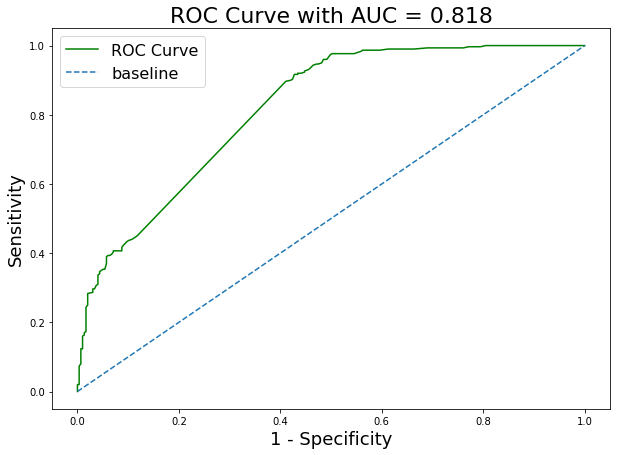

In [37]:
tvec_log_title = grid_fit(X_train['title'], y_train, X_test['selftext'], y_test, model = ('lr', LogisticRegression(solver = 'lbfgs')), vctrizer = 'tvec')

Train Score: 0.8546762589928057
Test Score: 0.7319932998324958
True Negatives: 176
False Positives: 121
False Negatives: 39
True Positives: 261
{'vec__max_df': 0.9, 'vec__max_features': 3000, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}


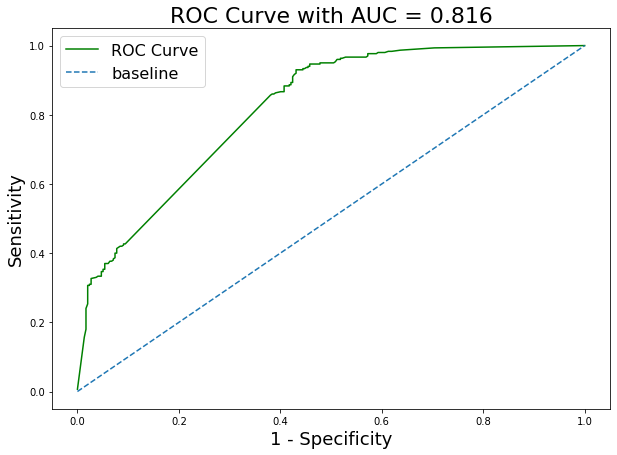

In [38]:
cvec_log_title = grid_fit(X_train['title'], y_train, X_test['selftext'], y_test, model = ('lr', LogisticRegression(solver = 'lbfgs')), vctrizer = 'cvec')

Train Score: 0.797841726618705
Test Score: 0.7939698492462312
True Negatives: 195
False Positives: 102
False Negatives: 21
True Positives: 279
{'vec__max_df': 0.9, 'vec__max_features': 1500, 'vec__min_df': 3, 'vec__ngram_range': (1, 2)}


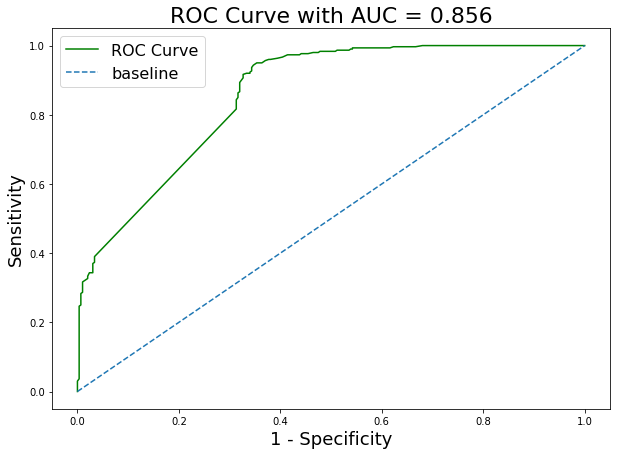

In [39]:
tvec_log_selftext = grid_fit(X_train['selftext'], y_train, X_test['selftext'], y_test, model = ('lr', LogisticRegression(solver = 'lbfgs')), vctrizer = 'tvec')

Train Score: 0.797841726618705
Test Score: 0.7822445561139029
True Negatives: 190
False Positives: 107
False Negatives: 23
True Positives: 277
{'vec__max_df': 0.9, 'vec__max_features': 3000, 'vec__min_df': 2, 'vec__ngram_range': (1, 2)}


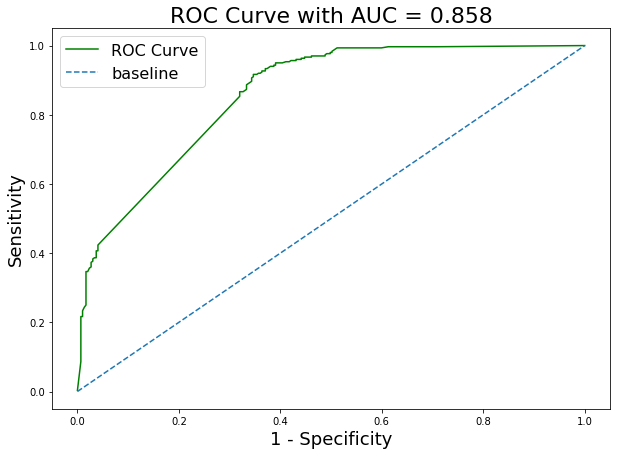

In [40]:
cvec_log_selftext = grid_fit(X_train['selftext'], y_train, X_test['selftext'], y_test, model = ('lr', LogisticRegression(solver = 'lbfgs')), vctrizer = 'cvec')

Train Score: 0.8812949640287769
Test Score: 0.8576214405360134
True Negatives: 232
False Positives: 65
False Negatives: 20
True Positives: 280
{'vec__max_df': 0.9, 'vec__max_features': 1500, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}


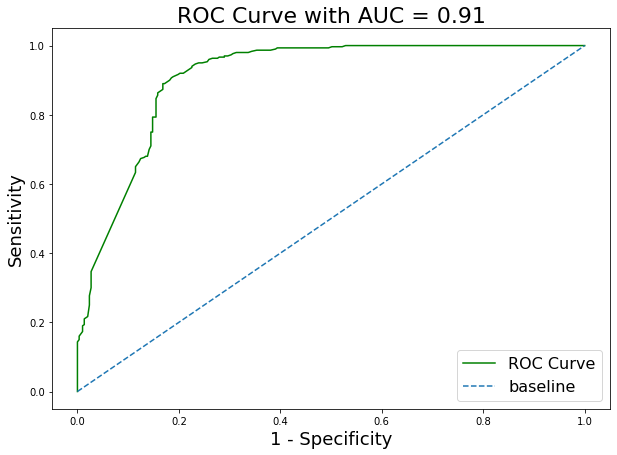

In [41]:
tvec_log_comments = grid_fit(X_train['comments'], y_train, X_test['comments'], y_test, model = ('lr', LogisticRegression(solver = 'lbfgs')), vctrizer = 'tvec')

Train Score: 0.874820143884892
Test Score: 0.847571189279732
True Negatives: 230
False Positives: 67
False Negatives: 24
True Positives: 276
{'vec__max_df': 0.9, 'vec__max_features': 2000, 'vec__min_df': 2, 'vec__ngram_range': (1, 1)}


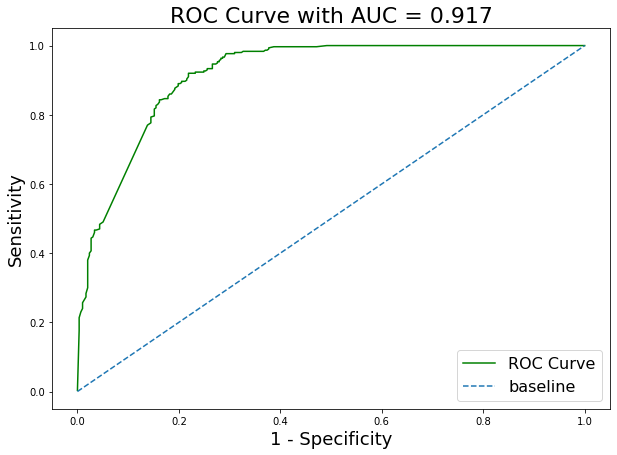

In [42]:
cvec_log_comments = grid_fit(X_train['comments'], y_train, X_test['comments'], y_test, model = ('lr', LogisticRegression(solver = 'lbfgs')), vctrizer = 'cvec')

Train Score: 0.9273381294964029
Test Score: 0.9262981574539364
True Negatives: 268
False Positives: 29
False Negatives: 15
True Positives: 285
{'vec__max_df': 0.9, 'vec__max_features': 3000, 'vec__min_df': 3, 'vec__ngram_range': (1, 1)}


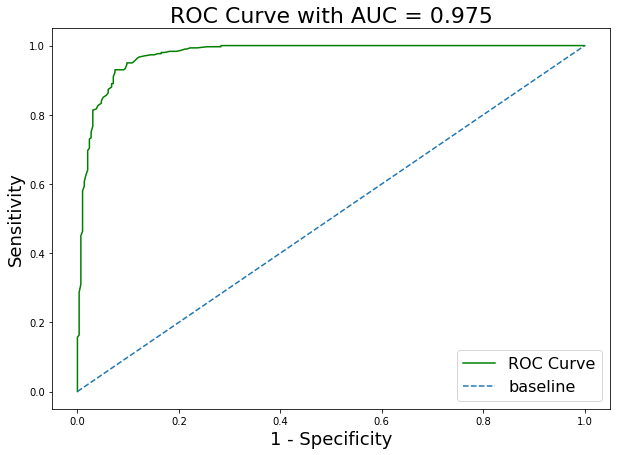

In [43]:
tvec_log_combined = grid_fit(X_train['combined'], y_train, X_test['combined'], y_test, model = ('lr', LogisticRegression(solver = 'lbfgs')), vctrizer = 'tvec')

Train Score: 0.9136690647482014
Test Score: 0.9195979899497487
True Negatives: 264
False Positives: 33
False Negatives: 15
True Positives: 285
{'vec__max_df': 0.9, 'vec__max_features': 4000, 'vec__min_df': 2, 'vec__ngram_range': (1, 1)}


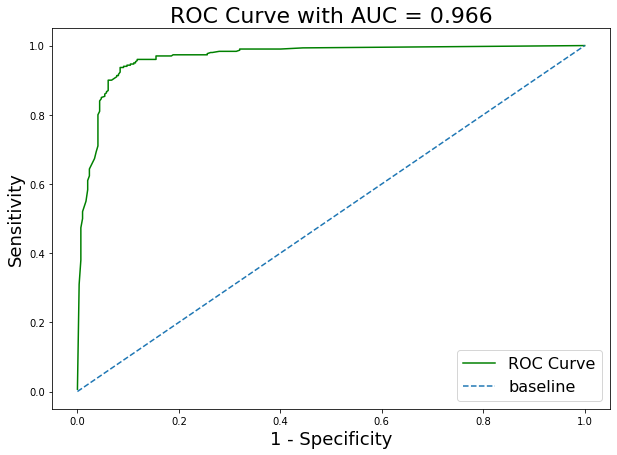

In [44]:
cvec_log_combined = grid_fit(X_train['combined'], y_train, X_test['combined'], y_test, model = ('lr', LogisticRegression(solver = 'lbfgs')), vctrizer = 'cvec')

### 6.2 Investigating Features <a id='Log Features'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

### Top 25 Features for FPL

In [47]:
pd.DataFrame([tvec_log_title[3]['feature'].head(25), 
              tvec_log_selftext[3]['feature'].head(25), 
              tvec_log_comments[3]['feature'].head(25), 
              tvec_log_combined[3]['feature'].head(25),
              cvec_log_title[3]['feature'].head(25),
              cvec_log_selftext[3]['feature'].head(25),
              cvec_log_comments[3]['feature'].head(25),
              cvec_log_combined[3]['feature'].head(25)], 
             index = ['tvec title', 'tvec selftext', 'tvec comments', 'tvec combined', 
                     'cvec title', 'cvec selftext', 'cvec comments', 'cvec combined']).transpose()

,tvec title,tvec selftext,tvec comments,tvec combined,cvec title,cvec selftext,cvec comments,cvec combined
0,gw,gw,week,gw,gw,gw,kdb,gw
1,xi,week,point,week,xi,injury,point,gameweek
2,gameweek,point,kdb,point,gameweek,october,starting,fantasy
3,start,injury,gw,gameweek,fantasy,ed,week,ep
4,net,price,start,fantasy,net,fc,gw,episode
5,point,salah,bench,meme,wildcard,pretty,start,clean
6,net transfer,fantasy,captain,start,net transfer,captain,clean,raw
7,wildcard,captain,sterling,kdb,point,official,lad,xi
8,salah,sterling,fixture,captain,start,james,injured,maker
9,october,fixture,meme,injury,salah,matip,bench,sheet


An explanation of some of these terms:

FPL Jargon:
<li> xi : starting eleven for a team
<li> gw: game week
<li> wildcard: an FPL game token used to change your team
<li> captain: captain for your fantasy team - captain gets double points</li>
    
Player Abbreviations (FPL players love to abbreviate):
<li>kdb: Kevin de Bruyne
<li>taa: Trent Alexander Arnold
    
FPL players seem very interested in players - particular the ones that give a good point return relative to their cost.
This reinforces what we found out from the baseline model.

### Top 25 Features for EPL

In [46]:
log_lowest_feats = pd.DataFrame([tvec_log_title[3]['feature'].tail(25).values, 
                                  tvec_log_selftext[3]['feature'].tail(25), 
                                  tvec_log_comments[3]['feature'].tail(25), 
                                  tvec_log_combined[3]['feature'].tail(25),
                                  cvec_log_title[3]['feature'].tail(25),
                                  cvec_log_selftext[3]['feature'].tail(25),
                                  cvec_log_comments[3]['feature'].tail(25),
                                  cvec_log_combined[3]['feature'].tail(25)], 
                                 index = ['tvec title', 'tvec selftext', 'tvec comments', 'tvec combined', 
                                         'cvec title', 'cvec selftext', 'cvec comments', 'cvec combined']).transpose()
log_lowest_feats.iloc[::-1] #Reverse orders, since tail takes the bottom 25 features without considering absolute value

,tvec title,tvec selftext,tvec comments,tvec combined,cvec title,cvec selftext,cvec comments,cvec combined
24,club,fan,club,club,club,fan,club,premier
23,premier league,var,football,premier,var,watch,football,var
22,premier,club,fan,fan,premier league,van,money,deal
21,var,year,var,var,premier,english,calendar,club
20,tottenham,icon,signing,football,tottenham,var,saturday,tottenham
19,league,watch,united,league,striker,oo,cb,signing
18,official,tottenham,ticket,sign,official,played,goal,gmspodcast
17,season,ticket,arsenal,signing,pl,tottenham,ll,sign
16,sign,english,championship,tottenham,ticket,signing,fan,interested
15,arsenal,league,money,arsenal,word sum,pl,final,van


Lots of discussion on VAR on r/EPL! Also, teams/clubs are more indicative of r/EPL, in contrast to the focus on players in r/FPL. There is general agreement among the 8 models as to what are the important words. Technical FPL terms like gw(game week), xi (starting 11), and kdb (nickname for Kevin de Bruyne) dominate the top 25 features for FPL, while the EPL reddit has an emphasis on more generic footballing nomenclature (e.g. signing, VAR, club, fan).

### Differentiating Teams

In [45]:
#We will look at our best performing model's features selected to look at what teams are differentiating FPL from EPL
tvec_log_combined[3][tvec_log_combined[3]['feature'].isin(team_list)].sort_values(by = 'coef', ascending = True)

,coef,feature
85,-0.692644,watford
269,-0.353725,leicester
472,-0.242555,pool
602,-0.199185,burnley
729,-0.161617,bournemouth
1050,-0.096775,southampton
1736,0.004072,norwich
2491,0.139241,brighton
2751,0.254606,everton
2840,0.325824,crystal


Negative coefficients mean the team are more indicative of r/FPL. Positive coefficients mean the team are more indicative of r/EPL.

Very interesting results here! Tottenham is very popular on EPL, but not so much on FPL (their players have been performing really poorly in the last few weeks, so their players aren't very popular in FPL circles). As highlighted before, FPL is interested in the less popular teams that give good value for their players in the FPL game (cheap players, with good points returns).

As might be expected, the most popular football teams (man u, tottenham, city) are more frequently discussed on r/EPL.

### Players that differentiate

Below, we have the top 25 players discussed by r/FPL.

In [48]:
#We will look at our best performing model's features selected to look at what players+teams are differentiating FPL from EPL
tvec_log_combined[3][tvec_log_combined[3]['feature'].isin(epl_players)].sort_values(by = 'coef', ascending = True).head(25)

,coef,feature
11,-1.650847,sterling
17,-1.314611,salah
18,-1.285031,mount
19,-1.238638,greenwood
21,-1.233254,son
22,-1.227731,aguero
24,-1.164465,lundstram
25,-1.126874,pukki
26,-1.101163,tomori
28,-1.081017,cantwell


Below, we have the top 25 players/teams mentioned by r/EPL.

In [49]:
#We will look at our best performing model's features selected to look at what players are differentiating EPL from FPL
tvec_log_combined[3][tvec_log_combined[3]['feature'].isin(epl_players)].sort_values(by = 'coef', ascending = True).tail(25)

,coef,feature
2754,0.255644,morrison
2761,0.258600,lucas
2775,0.266621,ayoze
2779,0.270044,claudio
2787,0.278583,zaha
2797,0.287756,christian
2798,0.288004,celso
2807,0.292368,frank
2808,0.292783,vincent
2813,0.299353,dijk


<b> Analysis of Players </b>

Interestingly, r/EPL tends to discuss managers/retired players more (e.g. henry, pochettino), and mention teams more than players. There are also different players on each list - Ashley Young is often mentioned in r/EPL, but is seldom mentioned in r/FPL (because his returns are terrible, points wise).

### 6.3 Summary of Models and Analysis <a id='Log Analysis'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

The table below summarizes the accuracy scores from the 8 models.

In [53]:
log_df = pd.DataFrame([[tvec_log_title[1], tvec_log_selftext[1],  tvec_log_comments[1],  tvec_log_combined[1]],
                     [cvec_log_title[1],  cvec_log_selftext[1], cvec_log_comments[1], cvec_log_combined[1]]],
                    index = ['tvec', 'cvec'], columns = ['title', 'selftext', 'comments', 'combined'])
log_df

,title,selftext,comments,combined
tvec,0.740369,0.793970,0.857621,0.926298
cvec,0.731993,0.782245,0.847571,0.919598


The table below summarizes the AUC scores from the 8 models.

In [54]:
log_df_AUC = pd.DataFrame([[tvec_log_title[2], tvec_log_selftext[2],  tvec_log_comments[2],  tvec_log_combined[2]],
                     [cvec_log_title[2],  cvec_log_selftext[2], cvec_log_comments[2], cvec_log_combined[2]]],
                    index = ['tvec', 'cvec'], columns = ['title', 'selftext', 'comments', 'combined'])
log_df_AUC

,title,selftext,comments,combined
tvec,0.818,0.856,0.910,0.975
cvec,0.816,0.858,0.917,0.966


As might be expected, the more features you feed the model (more words), the greater the predictive power. Tfidf outperformed countvectorizer once again, and using a logisticregression model, title alone provides less predictive power than Naive Bayes.

The logistic regression model, however, was very useful in providing insights into player and team preferences for r/EPL and r/FPL.

# 7. SVM Linear <a id='SVM'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

Here, we will run a SVM Linear model on our 4 datasets, using 2 vectorizers, for a total of 8 data sets.
The reason the linear SVM model is selected is because only the linear version allows us to investigate coefficients. The other variants of SVM may have stronger predicitive powers, but the inability to investigate features is a drawback since these variants are generally black boxes which are hard to interpret.

However, the SVM linear coefficients aren't necessarily indicative of strength, though they do indiciate directionality.
From a helpful and well explained stackoverflow post <a href='https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights'>here</a></div>:

    1) Recall that in linear SVM, the result is a hyperplane that separates the classes as best as possible. The weights represent this hyperplane, by giving you the coordinates of a vector which is orthogonal to the hyperplane - these are the coefficients given by svm.coef_. Let's call this vector w.

    2) What can we do with this vector? It's direction gives us the predicted class, so if you take the dot product of any point with the vector, you can tell on which side it is: if the dot product is positive, it belongs to the positive class, if it is negative it belongs to the negative class.

We will therefore run this model, see how well it performs, and investigate the direction of features' coefficients.

### 7.1 Modelling each Dataset <a id='SVM Models'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

Train Score: 0.862589928057554
Test Score: 0.8442211055276382
True Negatives: 235
False Positives: 62
False Negatives: 31
True Positives: 269
{'vec__max_df': 0.9, 'vec__max_features': 2000, 'vec__min_df': 1, 'vec__ngram_range': (1, 1)}


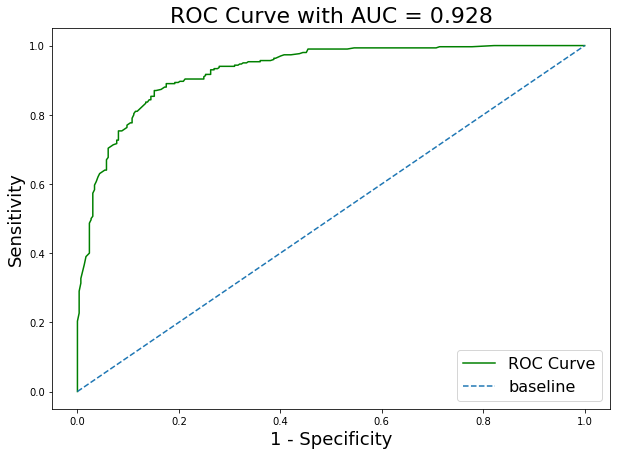

In [55]:
tvec_svm_title = grid_fit(X_train['title'], y_train, X_test['title'], y_test, model = ('svm', SVC(kernel = 'linear', probability = True)), vctrizer = 'tvec')

Train Score: 0.8431654676258993
Test Score: 0.8274706867671692
True Negatives: 234
False Positives: 63
False Negatives: 40
True Positives: 260
{'vec__max_df': 0.9, 'vec__max_features': 2000, 'vec__min_df': 1, 'vec__ngram_range': (1, 1)}


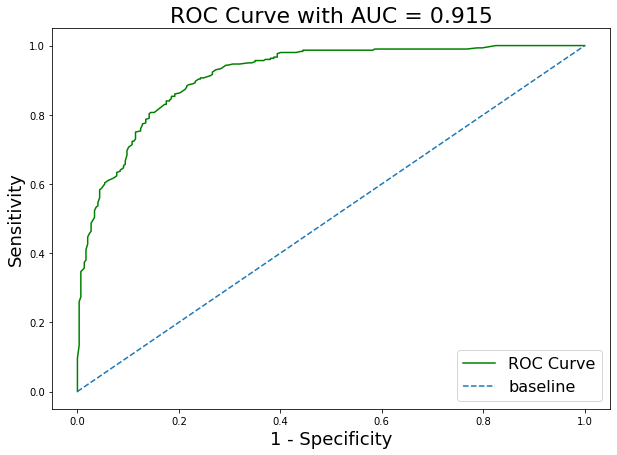

In [56]:
cvec_svm_title = grid_fit(X_train['title'], y_train, X_test['title'], y_test, model = ('svm', SVC(kernel = 'linear', probability = True)), vctrizer = 'cvec')

Train Score: 0.7856115107913669
Test Score: 0.7839195979899497
True Negatives: 184
False Positives: 113
False Negatives: 16
True Positives: 284
{'vec__max_df': 0.9, 'vec__max_features': 2000, 'vec__min_df': 2, 'vec__ngram_range': (1, 2)}


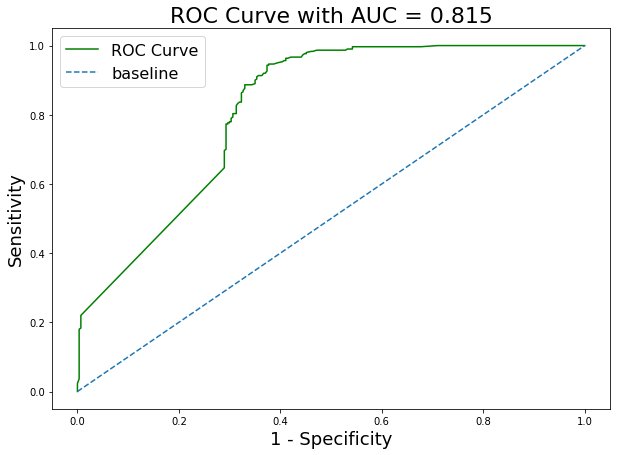

In [57]:
tvec_svm_selftext = grid_fit(X_train['selftext'], y_train, X_test['selftext'], y_test, model = ('svm', SVC(kernel = 'linear', probability = True)), vctrizer = 'tvec')

Train Score: 0.758273381294964
Test Score: 0.7604690117252931
True Negatives: 183
False Positives: 114
False Negatives: 29
True Positives: 271
{'vec__max_df': 0.9, 'vec__max_features': 4000, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}


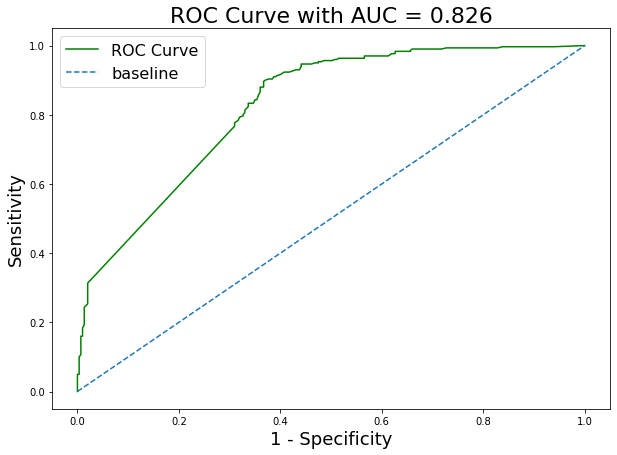

In [58]:
cvec_svm_selftext = grid_fit(X_train['selftext'], y_train, X_test['selftext'], y_test, model = ('svm', SVC(kernel = 'linear', probability = True)), vctrizer = 'cvec')

Train Score: 0.8755395683453238
Test Score: 0.8559463986599665
True Negatives: 229
False Positives: 68
False Negatives: 18
True Positives: 282
{'vec__max_df': 0.9, 'vec__max_features': 2000, 'vec__min_df': 2, 'vec__ngram_range': (1, 1)}


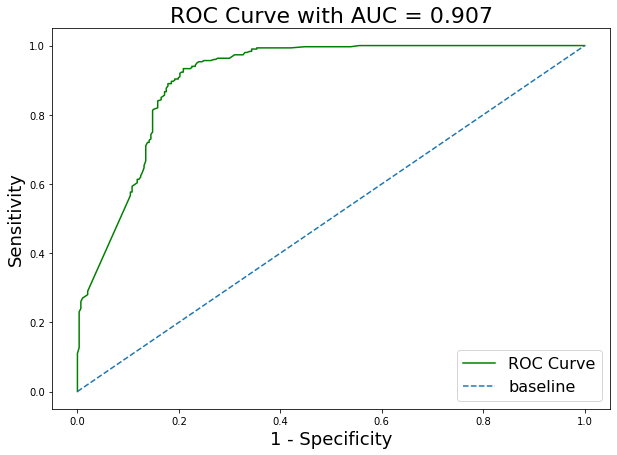

In [59]:
tvec_svm_comments = grid_fit(X_train['comments'], y_train, X_test['comments'], y_test, model = ('svm', SVC(kernel = 'linear', probability = True)), vctrizer = 'tvec')

Train Score: 0.8294964028776979
Test Score: 0.7939698492462312
True Negatives: 215
False Positives: 82
False Negatives: 41
True Positives: 259
{'vec__max_df': 0.9, 'vec__max_features': 2000, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}


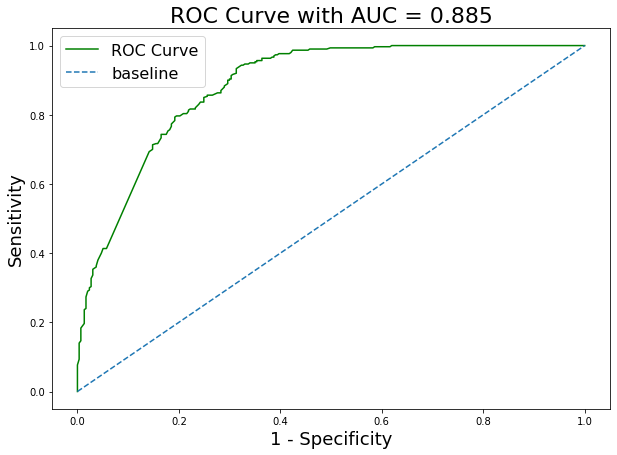

In [60]:
cvec_svm_comments = grid_fit(X_train['comments'], y_train, X_test['comments'], y_test, model = ('svm', SVC(kernel = 'linear', probability = True)), vctrizer = 'cvec')

Train Score: 0.9294964028776979
Test Score: 0.9262981574539364
True Negatives: 272
False Positives: 25
False Negatives: 19
True Positives: 281
{'vec__max_df': 0.9, 'vec__max_features': 2500, 'vec__min_df': 2, 'vec__ngram_range': (1, 2)}


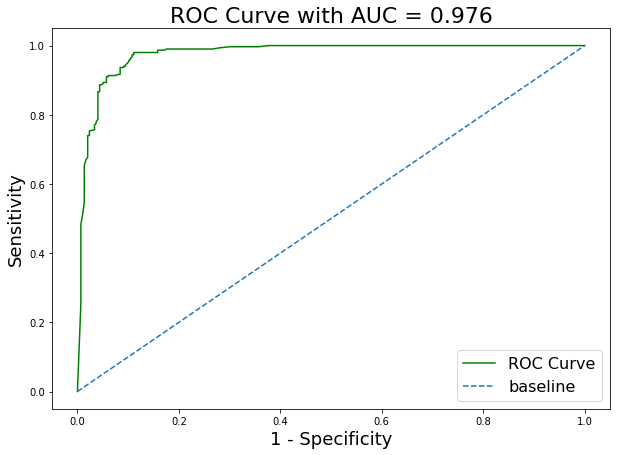

In [61]:
tvec_svm_combined = grid_fit(X_train['combined'], y_train, X_test['combined'], y_test, model = ('svm', SVC(kernel = 'linear', probability = True)), vctrizer = 'tvec')

Train Score: 0.8942446043165467
Test Score: 0.9011725293132329
True Negatives: 258
False Positives: 39
False Negatives: 20
True Positives: 280
{'vec__max_df': 0.9, 'vec__max_features': 3500, 'vec__min_df': 3, 'vec__ngram_range': (1, 1)}


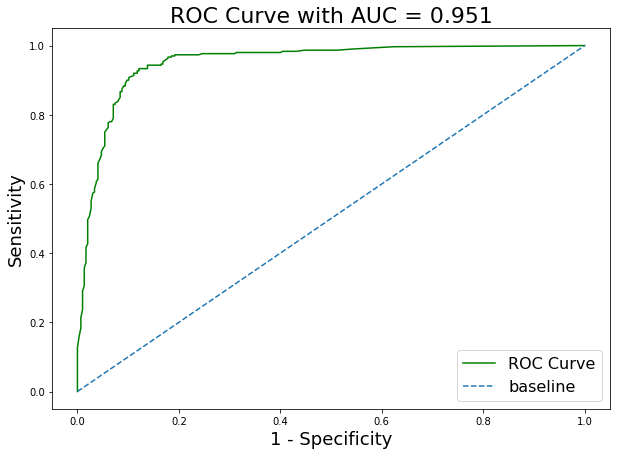

In [62]:
cvec_svm_combined = grid_fit(X_train['combined'], y_train, X_test['combined'], y_test, model = ('svm', SVC(kernel = 'linear', probability = True)), vctrizer = 'cvec')

### 7.2 Feature Analysis <a id='SVM Features'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

### FPL features

In [63]:
pd.DataFrame([tvec_svm_title[3].sort_values(by = 0).head(25).index,
              tvec_svm_selftext[3].sort_values(by = 0).head(25).index,
              tvec_svm_comments[3].sort_values(by = 0).head(25).index,
              tvec_svm_combined[3].sort_values(by = 0).head(25).index,
              cvec_svm_title[3].sort_values(by = 0).head(25).index,
              cvec_svm_selftext[3].sort_values(by = 0).head(25).index,
              cvec_svm_comments[3].sort_values(by = 0).head(25).index,
              cvec_svm_combined[3].sort_values(by = 0).head(25).index],
            index = ['tvec_title', 'tvec_selftext', 'tvec_comments', 'tvec_combined',
                    'cvec_title', 'cvec_selftext', 'cvec_comments', 'cvec_combined']).transpose()

,tvec_title,tvec_selftext,tvec_comments,tvec_combined,cvec_title,cvec_selftext,cvec_comments,cvec_combined
0,gw,gw,point,gw,gw,ed,stuff,gw
1,xi,filler,week,fantasy,gameweek,fc,saka,gameweek
2,gameweek,fantasy,start,gameweek,xi,ay,safe,maker
3,point,injury,kdb,point,lineup,official,kun,ep
4,wildcard,captain,gw,start,replacement,gw,bellerin,matchweek
5,replacement,james,fixture,week,net,er,lad,raw
6,start,october,clean,xi,triple,wilson,christensen,fantasy
7,training,price,lad,greenwood,price,sa,magnus,episode
8,scored,firmino,bench,option,wildcard,ul,starting,sell
9,matip,footytistics,fantasy,captain,matip,october,injured,position


### EPL Features

In [64]:
pd.DataFrame([tvec_svm_title[3].sort_values(by = 0).tail(25).index,
              tvec_svm_selftext[3].sort_values(by = 0).tail(25).index,
              tvec_svm_comments[3].sort_values(by = 0).tail(25).index,
              tvec_svm_combined[3].sort_values(by = 0).tail(25).index,
              cvec_svm_title[3].sort_values(by = 0).tail(25).index,
              cvec_svm_selftext[3].sort_values(by = 0).tail(25).index,
              cvec_svm_comments[3].sort_values(by = 0).tail(25).index,
              cvec_svm_combined[3].sort_values(by = 0).tail(25).index],
            index = ['tvec_title', 'tvec_selftext', 'tvec_comments', 'tvec_combined',
                    'cvec_title', 'cvec_selftext', 'cvec_comments', 'cvec_combined']).transpose()

,tvec_title,tvec_selftext,tvec_comments,tvec_combined,cvec_title,cvec_selftext,cvec_comments,cvec_combined
0,happened,going,ticket,premier league,striker,following,kinda,dani
1,maguire,chris,hey,window,marco,bruce,decent,awarded
2,europe,age,agree,manchester united,focus,cm,champion,prefer
3,frank,icon sub,line,buy,discussing,english,club,lot
4,wonder,released,cb,ability,afc,ready,list,listen
5,season,link,europa,signing,ticket,amp,click,van
6,ole,premier league,buy,bbc,matchday,link,left,upcoming
7,sign,prediction,var,subbed minute,nbc,stadium,finish,sign
8,song,cm,fa,predicted,club,schedule,trying,buy
9,marco,ronaldo,maguire,van,mario,van,ready,link


In [65]:
#We will look at our best performing model's features selected to look at what teams are differentiating FPL from EPL
tvec_svm_combined[3][tvec_svm_combined[3].index.isin(team_list)].sort_values(by = 0, ascending = True)

,0
watford,-0.903418
pool,-0.442560
bournemouth,-0.331464
leicester,-0.273436
burnley,-0.082836
southampton,-0.076746
brighton,-0.072708
norwich,-0.047433
city,-0.015661
everton,0.028330


Similar findings as the log model - the big, popular teams like manchester, tottenham, arsenal (colloquially known as the big 6) are more popular on r/EPL, while the smaller teams are popular on r/FPL. Overall, it is also interesting to note that r/FPL tends to discuss <u>players</u>, while r/EPL discusses <u>clubs</u>. This is because FPL as a game depends on individual players' performances.

### Players + Teams that Differentiate

#### Players popular on r/FPL

In [66]:
#We will look at our best performing model's features selected to look at what teams are differentiating FPL from EPL
tvec_svm_combined[3][tvec_svm_combined[3].index.isin(epl_players)].sort_values(by = 0, ascending = True).head(25)

,0
greenwood,-1.500185
chance,-1.269164
romero,-1.192997
kelly,-1.108960
son,-1.019730
ben,-0.975258
matip,-0.957790
mahrez,-0.934011
wilson,-0.879629
kean,-0.870732


#### Players popular on r/EPL 

In [67]:
#We will look at our best performing model's features selected to look at what teams/players are differentiating FPL from EPL
tvec_svm_combined[3][tvec_svm_combined[3].index.isin(epl_players)].sort_values(by = 0, ascending = False).head(25)

,0
van,0.904035
maguire,0.807307
lucas,0.804626
sane,0.775195
ozil,0.772917
harvey,0.727403
kyle,0.711411
silva,0.614586
chris,0.584967
leno,0.537645


<b>Analysis</b>

As noted in the logistic regression model, teams are prioritized over players in r/EPL. There's also a marked difference in players redditors are interested in.

### 7.3 Summary of Model and Analysis<a id='SVM Analysis'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

The table below summarizes the accuracy scores from the 8 models.

Similar findings as before - the more features fed to the model, the better it performs. However, SVM Linear is able to make fairly accurate predictions (comparable to Naive Bayes) using only the title field. This is surprising, because the title fields on average contain 10 words.

In [68]:
svm_df = pd.DataFrame([[tvec_svm_title[1], tvec_svm_selftext[1],  tvec_svm_comments[1],  tvec_svm_combined[1]],
                     [cvec_svm_title[1],  cvec_svm_selftext[1], cvec_svm_comments[1], cvec_svm_combined[1]]],
                    index = ['tvec', 'cvec'], columns = ['title', 'selftext', 'comments', 'combined'])
svm_df

,title,selftext,comments,combined
tvec,0.844221,0.783920,0.855946,0.926298
cvec,0.827471,0.760469,0.793970,0.901173


The table below summarizes the AUC scores from the 8 models.

In [87]:
svm_df_AUC = pd.DataFrame([[tvec_svm_title[2], tvec_svm_selftext[2],  tvec_svm_comments[2],  tvec_svm_combined[2]],
                     [cvec_svm_title[2],  cvec_svm_selftext[2], cvec_svm_comments[2], cvec_svm_combined[2]]],
                    index = ['tvec', 'cvec'], columns = ['title', 'selftext', 'comments', 'combined'])
svm_df_AUC

,title,selftext,comments,combined
tvec,0.928,0.815,0.907,0.976
cvec,0.915,0.826,0.885,0.951


# 8. Decision Tree <a id='Decision'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

Here, we will run a Decision Tree model on our 4 datasets, using 2 vectorizers, for a total of 8 data sets.
Similar to the linear SVM model, the Decision Tree model is selected is because of its interpretability. The other variants (Random Forests or Extra Trees) may have stronger predicitive powers, but the inability or unreliability of feature explanation is a drawback.

For the decision tree, feature strength/directionality is not determined by coefficients. Rather, it represents the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.

As for the depth of the tree, we will use the default setting to let it run until all leaves are pure (min samples = 2, min leaf = 1). This greatly overfits the data, but in this case we are trying to make inferences based on the current set, so it is fine for it to overfit. For future models (e.g. a bagged model), the max depth can be set in the grid_fit function and run together with a grid search to derive a model with better variance and generalizability.

### 8.1 Modelling the Datasets<a id='DT Models'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

Train Score: 0.8050359712230216
Test Score: 0.7822445561139029
True Negatives: 221
False Positives: 76
False Negatives: 54
True Positives: 246
{'vec__max_df': 0.9, 'vec__max_features': 4000, 'vec__min_df': 3, 'vec__ngram_range': (1, 1)}


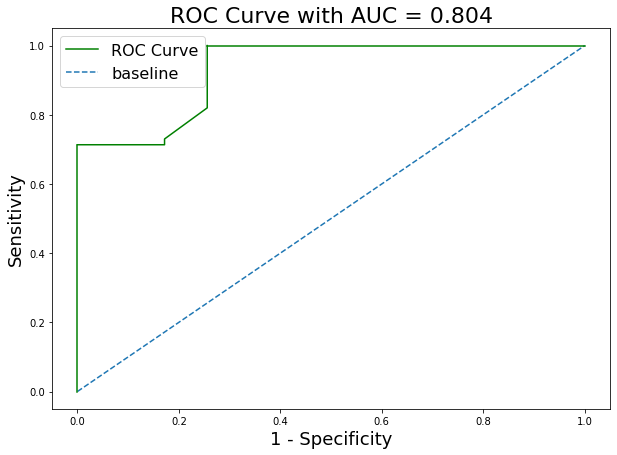

In [69]:
tvec_dt_title = grid_fit(X_train['title'], y_train, X_test['title'], y_test, model = ('dt', DecisionTreeClassifier()), vctrizer = 'tvec')

Train Score: 0.8071942446043165
Test Score: 0.7788944723618091
True Negatives: 250
False Positives: 47
False Negatives: 85
True Positives: 215
{'vec__max_df': 0.9, 'vec__max_features': 2000, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}


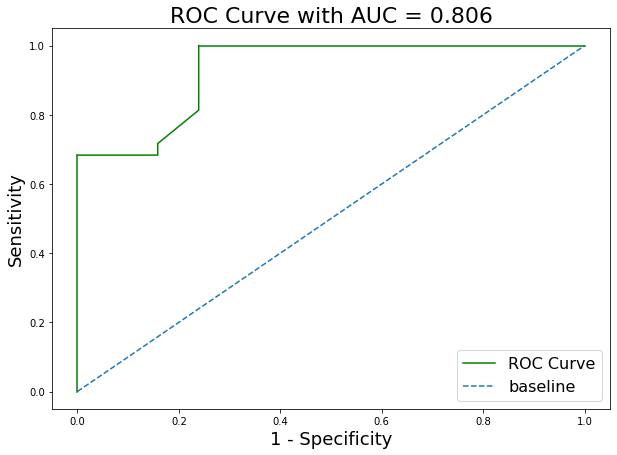

In [70]:
cvec_dt_title = grid_fit(X_train['title'], y_train, X_test['title'], y_test, model = ('dt', DecisionTreeClassifier()), vctrizer = 'cvec')

Train Score: 0.7266187050359713
Test Score: 0.7102177554438861
True Negatives: 165
False Positives: 132
False Negatives: 41
True Positives: 259
{'vec__max_df': 0.9, 'vec__max_features': 1500, 'vec__min_df': 3, 'vec__ngram_range': (1, 1)}


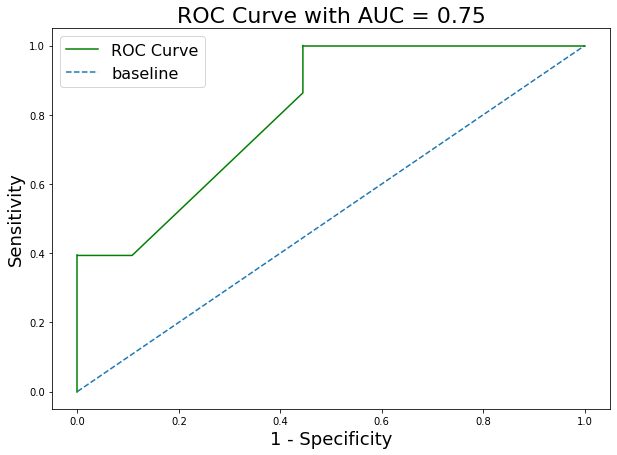

In [71]:
tvec_dt_selftext = grid_fit(X_train['selftext'], y_train, X_test['selftext'], y_test, model = ('dt', DecisionTreeClassifier()), vctrizer = 'tvec')

Train Score: 0.7294964028776978
Test Score: 0.7252931323283082
True Negatives: 167
False Positives: 130
False Negatives: 34
True Positives: 266
{'vec__max_df': 0.9, 'vec__max_features': 2500, 'vec__min_df': 2, 'vec__ngram_range': (1, 1)}


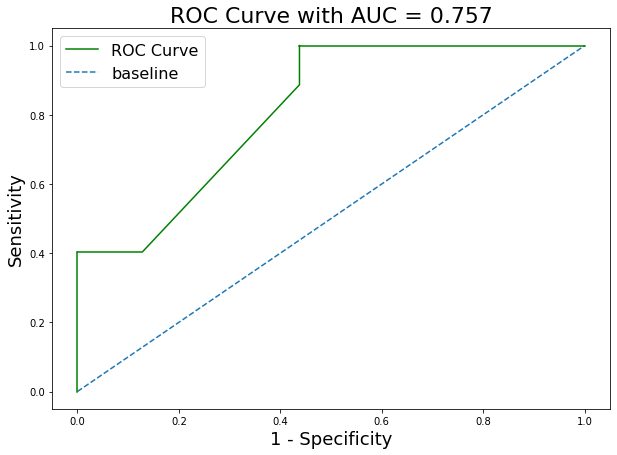

In [72]:
cvec_dt_selftext = grid_fit(X_train['selftext'], y_train, X_test['selftext'], y_test, model = ('dt', DecisionTreeClassifier()), vctrizer = 'cvec')

Train Score: 0.7856115107913669
Test Score: 0.7520938023450586
True Negatives: 203
False Positives: 94
False Negatives: 54
True Positives: 246
{'vec__max_df': 0.9, 'vec__max_features': 3000, 'vec__min_df': 2, 'vec__ngram_range': (1, 2)}


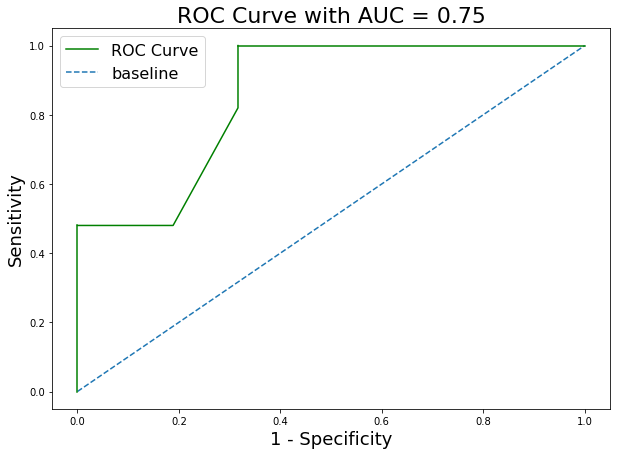

In [73]:
tvec_dt_comments = grid_fit(X_train['comments'], y_train, X_test['comments'], y_test, model = ('dt', DecisionTreeClassifier()), vctrizer = 'tvec')

Train Score: 0.7899280575539568
Test Score: 0.7453936348408711
True Negatives: 209
False Positives: 88
False Negatives: 64
True Positives: 236
{'vec__max_df': 0.9, 'vec__max_features': 2500, 'vec__min_df': 2, 'vec__ngram_range': (1, 1)}


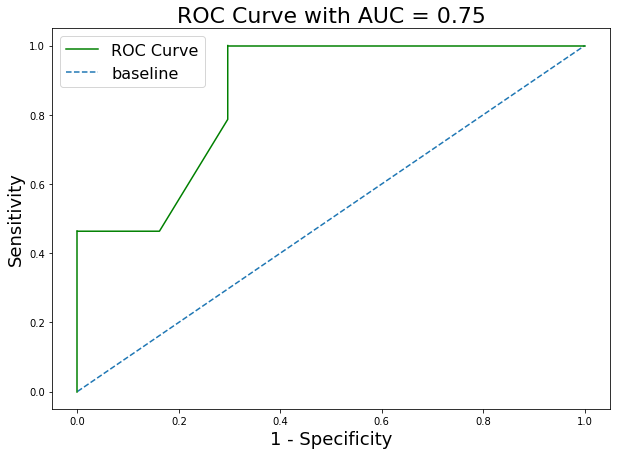

In [74]:
cvec_dt_comments = grid_fit(X_train['comments'], y_train, X_test['comments'], y_test, model = ('dt', DecisionTreeClassifier()), vctrizer = 'cvec')

Train Score: 0.8597122302158273
Test Score: 0.8157453936348409
True Negatives: 252
False Positives: 45
False Negatives: 65
True Positives: 235
{'vec__max_df': 0.9, 'vec__max_features': 2000, 'vec__min_df': 3, 'vec__ngram_range': (1, 2)}


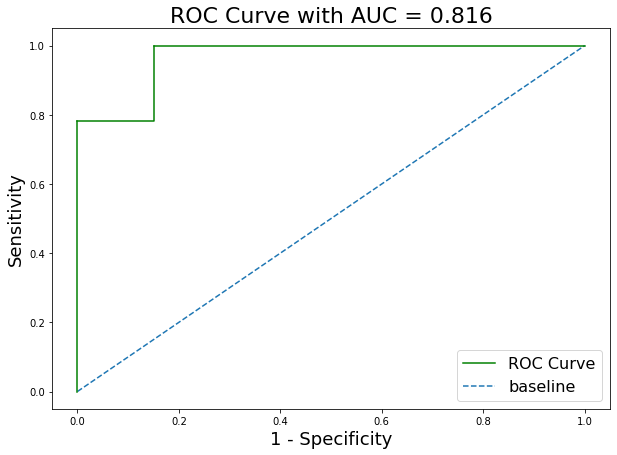

In [75]:
tvec_dt_combined = grid_fit(X_train['combined'], y_train, X_test['combined'], y_test, model = ('dt', DecisionTreeClassifier()), vctrizer = 'tvec')

Train Score: 0.8410071942446044
Test Score: 0.8241206030150754
True Negatives: 244
False Positives: 53
False Negatives: 52
True Positives: 248
{'vec__max_df': 0.9, 'vec__max_features': 3500, 'vec__min_df': 1, 'vec__ngram_range': (1, 1)}


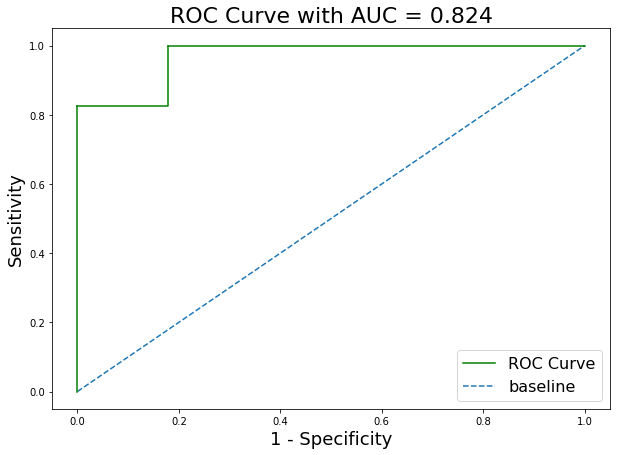

In [76]:
cvec_dt_combined = grid_fit(X_train['combined'], y_train, X_test['combined'], y_test, model = ('dt', DecisionTreeClassifier()), vctrizer = 'cvec')

### 8.2 Feature Analysis<a id='DT Features'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

In [77]:
pd.DataFrame([tvec_dt_title[3].sort_values(by ='coef', ascending = False)['feature'].head(25).values,
              tvec_dt_selftext[3].sort_values(by ='coef', ascending = False)['feature'].head(25).values,
              tvec_dt_comments[3].sort_values(by ='coef', ascending = False)['feature'].head(25).values,
              tvec_dt_combined[3].sort_values(by ='coef', ascending = False)['feature'].head(25).values,
              tvec_dt_title[3].sort_values(by ='coef', ascending = False)['feature'].head(25).values,
              tvec_dt_selftext[3].sort_values(by ='coef', ascending = False)['feature'].head(25).values,
              tvec_dt_comments[3].sort_values(by ='coef', ascending = False)['feature'].head(25).values,
              tvec_dt_combined[3].sort_values(by ='coef', ascending = False)['feature'].head(25).values],
            index = ['tvec_title', 'tvec_selftext', 'tvec_comments', 'tvec_combined', 'cvec_title', 'cvec_selftext',
                    'cvec_comments', 'cvec_combined']).transpose()

,tvec_title,tvec_selftext,tvec_comments,tvec_combined,cvec_title,cvec_selftext,cvec_comments,cvec_combined
0,gw,gw,week,gw,gw,gw,week,gw
1,premier,thread,kdb,kdb,premier,thread,kdb,kdb
2,gameweek,ownership,point,gameweek,gameweek,ownership,point,gameweek
3,october,injury,start,xi,october,injury,start,xi
4,xi,fantasy,clean,clean,xi,fantasy,clean,clean
5,net,fixture,thread,injury,net,fixture,thread,injury
6,september,football,gw,cantwell,september,football,gw,cantwell
7,club,ae,club,start,club,ae,club,start
8,ha,mcginn,fan,posted,ha,mcginn,fan,posted
9,injury,league,lad,fantasy,injury,league,lad,fantasy


### Visualization of Decision Tree - Simplified Example

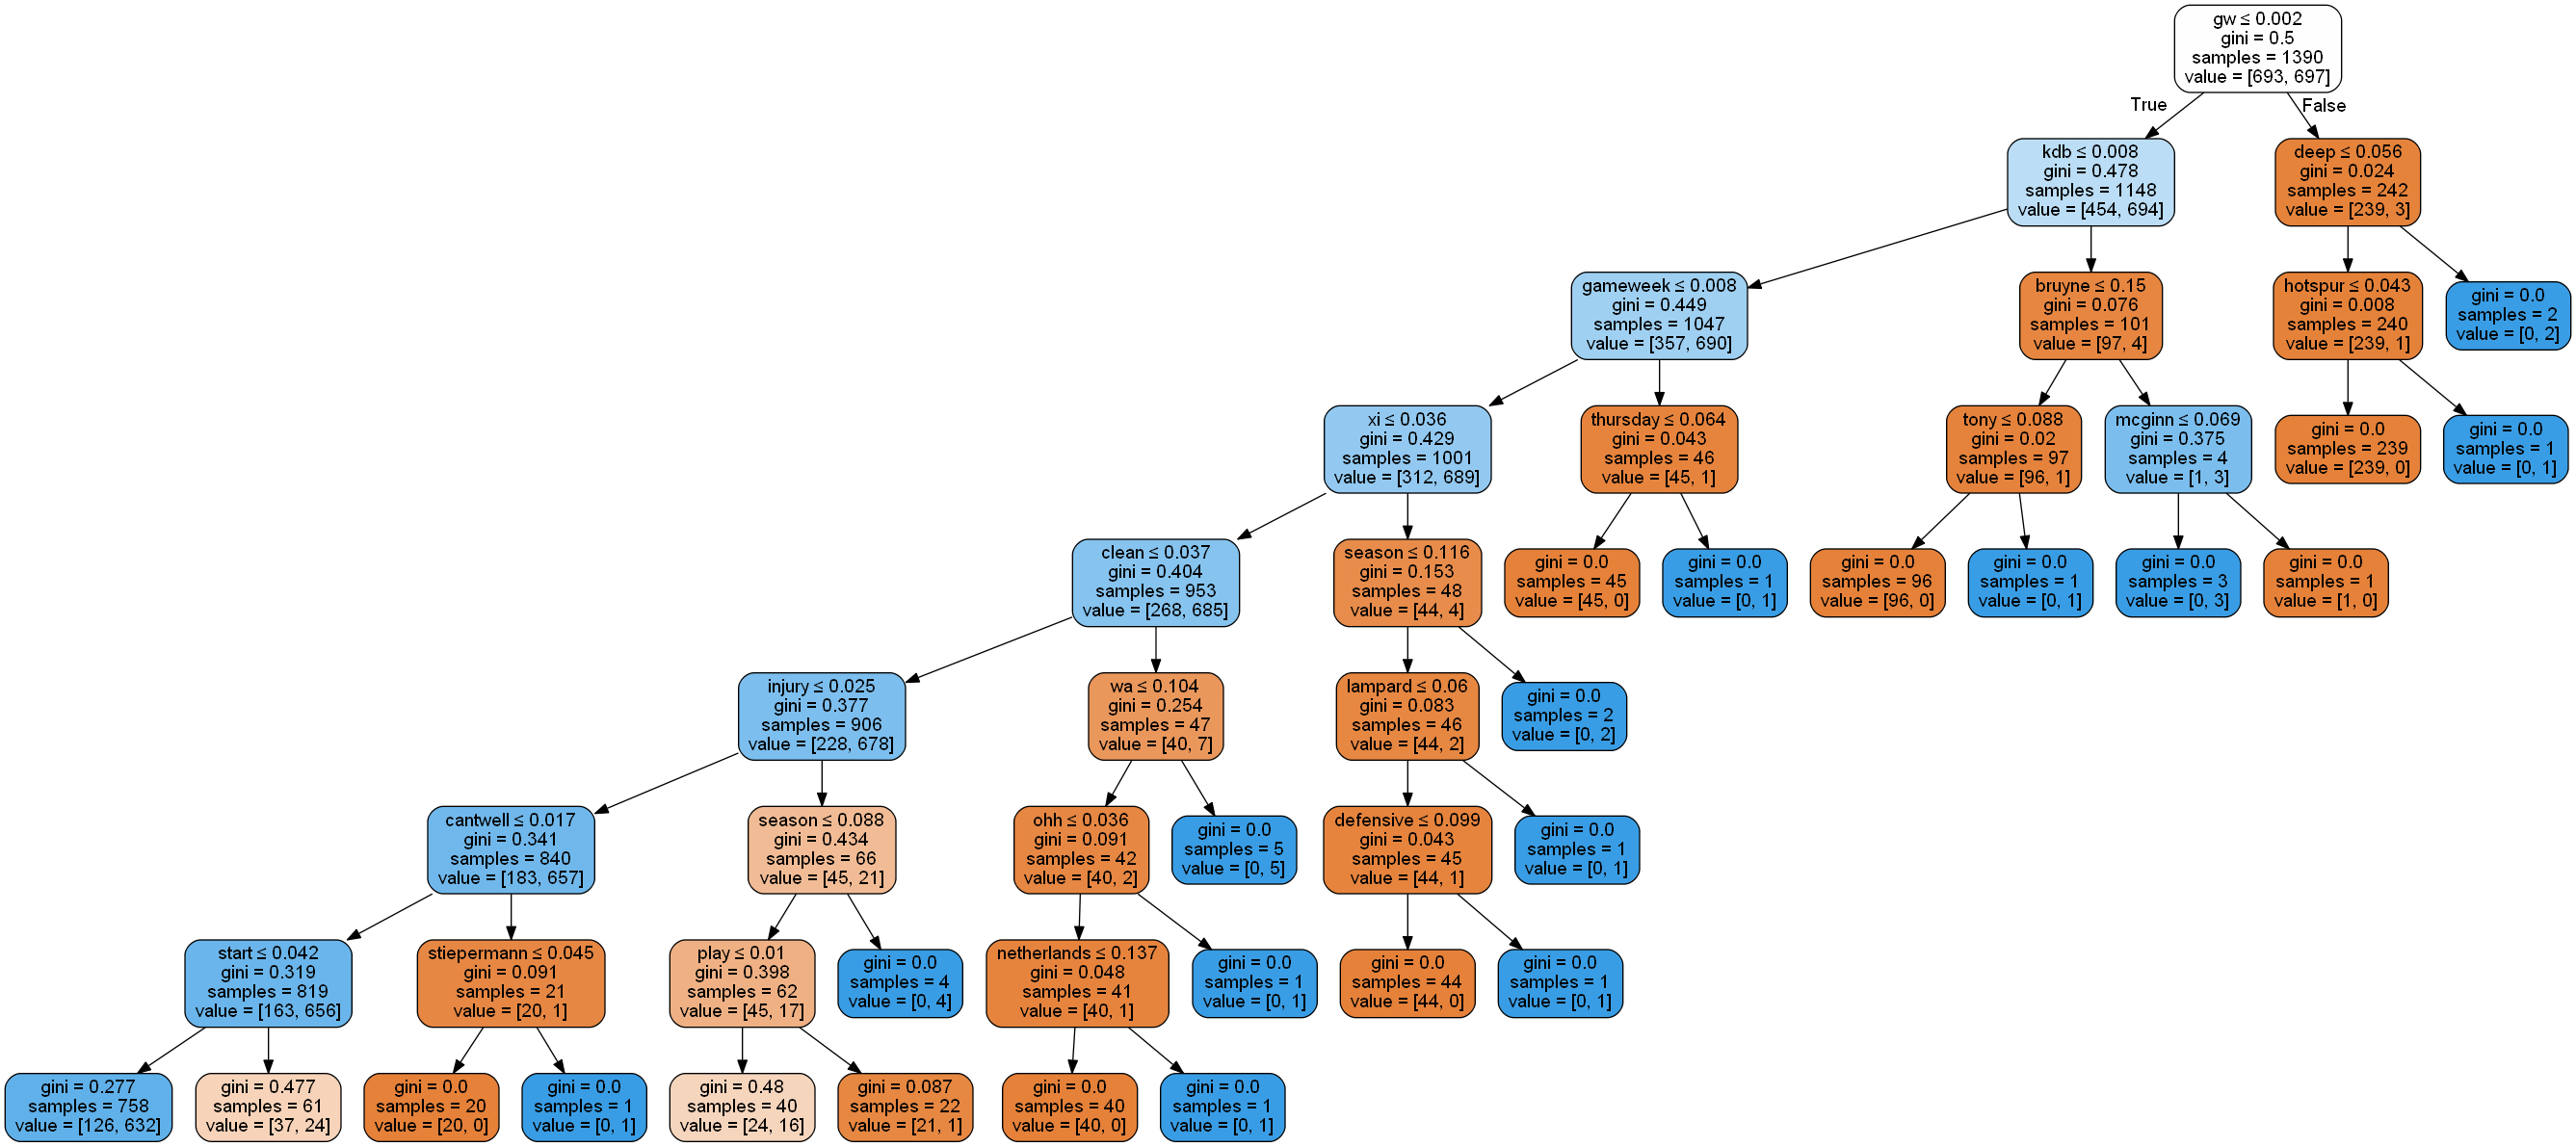

In [78]:
#Create a new tree with a lower depth (easier to visualize, compared to the 50 depth trees run in the model)
tvec = TfidfVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(['fpl', 'epl']))
tree_data = tvec.fit_transform(X_train['combined'])
clf = DecisionTreeClassifier(max_depth = 8)
clf.fit(tree_data, y_train)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names=tvec.get_feature_names(),
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

<img src='.\datasets\DecisionTree.png'>

The first split is on the FPL term 'gw' (gameweek), but the second is on 'kdb' (Kevin de Bruyne), a player! This, as repeated many many times by now, highlights how r/FPL is more focused on players rather than teams. Further down the tree, the splits happen on other players like Cantwell, Hanley, etc. Another interesting finding: this tree is an abbreviated version, but in a 20 depth tree run previously, the Decision Tree started splitting based on teams - if Tottenham was mentioned, it was more likely to be a r/EPL post. Food for thought.

### Players + Teams that Differentiate

In [79]:
#We will look at our best performing model's features selected to look at what teams are differentiating FPL from EPL
tvec_dt_combined[3][tvec_dt_combined[3]['feature'].isin(team_list)].sort_values(by = 'coef', ascending = False).head(10)

,coef,feature
84,0.0,arsenal
1077,0.0,newcastle
1798,0.0,villa
1754,0.0,united
1710,0.0,tottenham
1539,0.0,southampton
1495,0.0,sheffield
1240,0.0,pool
1103,0.0,norwich
967,0.0,manchester


Manchester united remains one of the more popular teams, but the decision tree model finds that teams don't really have significant predictive power (gini impurity wise) outside of the Manchester teams and Norwich.

In [80]:
#We will look at our best performing model's features selected to look at what teams are differentiating FPL from EPL
tvec_dt_combined[3][tvec_dt_combined[3]['feature'].isin(epl_players)].sort_values(by = 'coef', ascending = False).head(10)

,coef,feature
1993,0.034272,cantwell
1988,0.013617,mount
1981,0.009602,ben
1979,0.007593,chance
1978,0.007545,bernardo
1976,0.007519,mahrez
1974,0.007431,wilson
1968,0.005669,christian
1967,0.005424,kante
1966,0.005382,son


These are the top 10 players that distinguish r/FPL from r/EPL.

### 8.3 Analysis of Decision Tree Model<a id='DT Analysis'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

The table below summarizes the accuracy scores from the 8 models.

In [81]:
dt_df = pd.DataFrame([[tvec_dt_title[1], tvec_dt_selftext[1],  tvec_dt_comments[1],  tvec_dt_combined[1]],
                     [cvec_dt_title[1],  cvec_dt_selftext[1], cvec_dt_comments[1], cvec_dt_combined[1]]],
                    index = ['tvec', 'cvec'], columns = ['title', 'selftext', 'comments', 'combined'])
dt_df

,title,selftext,comments,combined
tvec,0.782245,0.710218,0.752094,0.815745
cvec,0.778894,0.725293,0.745394,0.824121


The table below summarizes the AUC scores from the 8 models.

In [86]:
dt_df_AUC = pd.DataFrame([[tvec_dt_title[2], tvec_dt_selftext[2],  tvec_dt_comments[2],  tvec_dt_combined[2]],
                     [cvec_dt_title[2],  cvec_dt_selftext[2], cvec_dt_comments[2], cvec_dt_combined[2]]],
                    index = ['tvec', 'cvec'], columns = ['title', 'selftext', 'comments', 'combined'])
dt_df_AUC 

,title,selftext,comments,combined
tvec,0.804,0.750,0.75,0.816
cvec,0.806,0.757,0.75,0.824


Similar to before, the Tfidf Vectorizer outperformed the Count Vectorizer, though there was general consensus as to what the important terms were. Predictive power for Decision Tree was lower compared to the logistic and SVM models.

# Conclusion <a id='Conclusion'></a> 
<div align="right"><a href='#Table of Contents'>Back to Table of Contents</a></div>

### Summary of All Model Performance (Tfidf Only)

In [82]:
pd.DataFrame([nb_df.loc['tvec'].tolist(),
             log_df.loc['tvec'].tolist(), 
             svm_df.loc['tvec'].tolist(),
             dt_df.loc['tvec'].tolist()],
            columns = ['title', 'selftext','comments','combined'],
            index = ['Naive Bayes', 'Log Reg', 'SVM Linear', 'Decision Tree'])

,title,selftext,comments,combined
Naive Bayes,0.834171,0.782245,0.869347,0.917923
Log Reg,0.740369,0.793970,0.857621,0.926298
SVM Linear,0.844221,0.783920,0.855946,0.926298
Decision Tree,0.782245,0.710218,0.752094,0.815745


In [90]:
pd.DataFrame([nb_df_AUC.loc['tvec'].tolist(),
             log_df_AUC.loc['tvec'].tolist(), 
             svm_df_AUC.loc['tvec'].tolist(),
             dt_df_AUC.loc['tvec'].tolist()],
            columns = ['title', 'selftext','comments','combined'],
            index = ['Naive Bayes', 'Log Reg', 'SVM Linear', 'Decision Tree'])

,title,selftext,comments,combined
Naive Bayes,0.919,0.868,0.925,0.971
Log Reg,0.818,0.856,0.910,0.975
SVM Linear,0.928,0.815,0.907,0.976
Decision Tree,0.804,0.750,0.750,0.816


In terms of predictive and explanatory power, the logistic regressions and SVM models came close. They barely outperformed the Naive Bayes baseline model, but provided much better insight through their coefficients.

### Summary of r/FPL Feature Importances (Tfidf Only, Combined Dataset, NB Excluded)

In [83]:
pd.DataFrame([tvec_log_combined[3].sort_values(by ='coef', ascending = True)['feature'].head(25).values,
             tvec_svm_combined[3].sort_values(by = 0).head(25).index,
             tvec_dt_combined[3].sort_values(by ='coef', ascending = False)['feature'].head(25).values],
            index = ['Log Reg', 'SVM Linear', 'Decision Tree']).transpose()

,Log Reg,SVM Linear,Decision Tree
0,gw,gw,gw
1,week,fantasy,kdb
2,point,gameweek,gameweek
3,gameweek,point,xi
4,fantasy,start,clean
5,meme,week,injury
6,start,xi,cantwell
7,kdb,greenwood,start
8,captain,option,posted
9,injury,captain,fantasy


In general, there is agreement between the three models as to what features are important.
As noted previously, the trend here is that players are mentioned very frequently, as well as the use of FPL jargon.

### Summary of r/EPL Feature Importances (Tfidf Only, Combined Dataset, NB/DT Excluded)

In [85]:
pd.DataFrame([tvec_nb_combined[3].sort_values(by ='pos class', ascending = True)['feat'].head(25).values,
              tvec_log_combined[3].sort_values(by ='coef', ascending = False)['feature'].head(25).values,
             tvec_svm_combined[3].sort_values(by = 0).tail(25).index],
            index = ['Naive Bayes', 'Log Reg', 'SVM Linear']).transpose()

,Naive Bayes,Log Reg,SVM Linear
0,domestic,club,premier league
1,celtic,premier,window
2,tifo,fan,manchester united
3,anwar,var,buy
4,anwar el,football,ability
5,incident,league,signing
6,note big,sign,bbc
7,notsoofficial,signing,subbed minute
8,notsoofficial reddit,tottenham,predicted
9,card bad,arsenal,van


### Implications for FPL

From our look into the defining features of the FPL and EPL subreddit, we make the following findings:

<br>
<li> <b> FPL is interested in players; EPL is interested in teams </b> : FPL is a game that focuses on the performance of individual players, so it is perhaps not surprising to find that player names are mentioned far more often in the FPL subreddit. EPL redditors, on the other hand, are interested in teams - they are excited when a team does well or poorly, and place a lower impetus on individual player performance.</li>
<br> 
<li> <b> FPL is full of FPL jargon </b>: FPL players have their own language! They use technical terms like XG (expected goals), XA (expected assists), 'clean sheet', 'blank', 'captaining'..</li>
<br>
<li> <b> Most popular teams </b> : The most popular teams on r/EPL, are, unsurprisingly, the big 6 teams. Conversely, the less popular teams are frequently discussed on r/FPL, since these are generally players with lower prices, greater value, and providing some return on points. An interesting strategy might be advertising to the fans of the less popular teams like Norwich and Bournemouth, since they might be surprised to find that their players are doing well on the FPl platform.</li>

</br>  
</br>
<li> <b> Marketing Considerations </b>: FPL is interested in players; EPL is interested in teams. Therefore, the marketing campaign on r/EPL should be team focused. r/FPL is full of FPL jargon - How do we ease EPL redditors into FPL? Most popular teams/players - Use the Big 6 football clubs, but also appeal to the supporters of the smaller clubs, particularly if their players are doing well in FPL

